In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

### 2. 加载历史股价

In [2]:
import pymysql

In [3]:
db = pymysql.connect(host="127.0.0.1",user='root',passwd='123456',database='stock_info')
cursor = db.cursor()

In [5]:
cursor.execute("select * from hs300_stock_price_pool where code='000001.XSHE';")
data = cursor.fetchall()

In [6]:
print(type(data))

<class 'tuple'>


In [7]:
df = pd.DataFrame(list(data))

In [9]:
df.head()

,0,1,2,3,4,5,6,7
0,786426,000001.XSHE,平安银行,1991-04-03,-0.74,-0.74,-0.74,-0.74
1,786427,000001.XSHE,平安银行,1991-04-04,-0.74,-0.74,-0.74,-0.74
2,786428,000001.XSHE,平安银行,1991-04-05,-0.74,-0.74,-0.74,-0.74
3,786429,000001.XSHE,平安银行,1991-04-06,-0.74,-0.74,-0.74,-0.74
4,786430,000001.XSHE,平安银行,1991-04-08,-0.74,-0.74,-0.74,-0.74


In [10]:
del df[0]

In [12]:

del df[2]
df.head()

,1,3,4,5,6,7
0,000001.XSHE,1991-04-03,-0.74,-0.74,-0.74,-0.74
1,000001.XSHE,1991-04-04,-0.74,-0.74,-0.74,-0.74
2,000001.XSHE,1991-04-05,-0.74,-0.74,-0.74,-0.74
3,000001.XSHE,1991-04-06,-0.74,-0.74,-0.74,-0.74
4,000001.XSHE,1991-04-08,-0.74,-0.74,-0.74,-0.74


In [13]:
df.rename(columns={1:"code",3:'date',4:'open',5:'close',6:'high',7:'low'},inplace=True)

In [14]:
df.head()

,code,date,open,close,high,low
0,000001.XSHE,1991-04-03,-0.74,-0.74,-0.74,-0.74
1,000001.XSHE,1991-04-04,-0.74,-0.74,-0.74,-0.74
2,000001.XSHE,1991-04-05,-0.74,-0.74,-0.74,-0.74
3,000001.XSHE,1991-04-06,-0.74,-0.74,-0.74,-0.74
4,000001.XSHE,1991-04-08,-0.74,-0.74,-0.74,-0.74


In [15]:
df.shape

(7415, 6)

In [16]:
df = df.set_index('date')

In [26]:
from datetime import date
df[:date.fromisoformat("2020-01-01")].iloc[:,[2]]

,close
date,
1991-04-03,-0.74
1991-04-04,-0.74
1991-04-05,-0.74
1991-04-06,-0.74
1991-04-08,-0.74
...,...
2019-12-25,15.90
2019-12-26,16.07
2019-12-27,16.23


In [27]:
training_set = df[:date.fromisoformat("2020-01-01")].iloc[:,[2]]

In [31]:
training_set.tail()

,close
date,
2019-12-25,15.90
2019-12-26,16.07
2019-12-27,16.23
2019-12-30,16.17
2019-12-31,16.05


In [28]:
test_set = df[date.fromisoformat("2020-01-01"):].iloc[:,[2]]

In [66]:
test_set.shape

(561, 1)

In [96]:
def plot_predictions(test_result,predict_result,stock_name):
    """
    test_result: 真实值
    predict_result: 预测值
    """
    # plt.figure(figsize=(12.8, 7.2))
    plt.plot(test_result,color='red',label="{} true stock_price".format(stock_name))
    plt.plot(predict_result,color='blue',label='{} predict stock price'.format(stock_name))
    plt.title("{} stock price".format(stock_name))
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

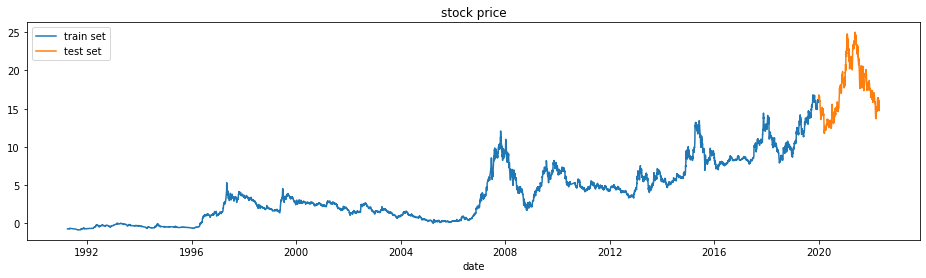

In [33]:
df['close'][:date.fromisoformat("2020-01-01")].plot(figsize=(16,4),legend=True)
df['close'][date.fromisoformat("2020-01-01"):].plot(figsize=(16,4),legend=True)
plt.title("stock price")
plt.legend(["train set","test set"])
plt.show()

In [138]:
# 正则化：将每一维度的特征映射到指定区间：[0,1]
sc = MinMaxScaler(feature_range=[0,1])
training_set_scaled = sc.fit_transform(training_set)

In [139]:
training_set_scaled.shape

(6854, 1)

In [146]:
# 创建序列数据集（训练和测试）
# 30 个时间步为一个样本，1个输出
x_train = []
y_train = []
for i in range(30,6854):
    x_train.append(training_set_scaled[i-30:i])
    y_train.append(training_set_scaled[i,0])
x_train,y_train = np.array(x_train),np.array(y_train)


In [143]:
x_train[0].shape

(30, 1)

In [128]:
x_train

array([[[0.0079096 ],
        [0.0079096 ],
        [0.0079096 ],
        ...,
        [0.01129944],
        [0.01129944],
        [0.01129944]],

       [[0.0079096 ],
        [0.0079096 ],
        [0.0079096 ],
        ...,
        [0.01129944],
        [0.01129944],
        [0.01129944]],

       [[0.0079096 ],
        [0.0079096 ],
        [0.0079096 ],
        ...,
        [0.01129944],
        [0.01129944],
        [0.01129944]],

       ...,

       [[0.95028249],
        [0.95649718],
        [0.95423729],
        ...,
        [0.95367232],
        [0.9480226 ],
        [0.95762712]],

       [[0.95649718],
        [0.95423729],
        [0.92259887],
        ...,
        [0.9480226 ],
        [0.95762712],
        [0.96666667]],

       [[0.95423729],
        [0.92259887],
        [0.92316384],
        ...,
        [0.95762712],
        [0.96666667],
        [0.96327684]]])

In [23]:
# LSTM的输入：（samples，sequence_length,features)
# reshape:训练集（3711,30）-->（3711,30,1）
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [149]:
y_train.shape

(6824,)

## 搭建LSTM模型，进行训练和预测

In [107]:
from keras.layers import ConvLSTM2D
model = Sequential()

# LSTM 第一层
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))

# LSTM 第二层
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))

# LSTM 第三层
model.add(LSTM(50))
model.add(Dropout(0.2))

# Dense层
model.add(Dense(units=1))



In [108]:
# 模型编译
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

# 模型训练
history = model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)


Epoch 1/10


ValueError: in user code:

    File "C:\Users\12554\miniconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\12554\miniconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\12554\miniconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\12554\miniconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\12554\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\12554\miniconda3\lib\site-packages\keras\engine\input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_5" (type Sequential).
    
    Input 0 of layer "conv_lstm2d_4" is incompatible with the layer: expected ndim=5, found ndim=3. Full shape received: (None, 30, 1)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 30, 1), dtype=float32)
      • training=True
      • mask=None


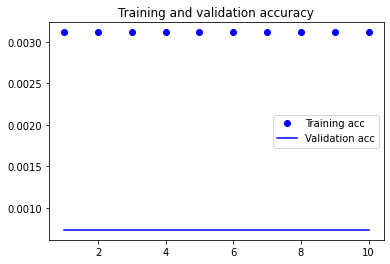

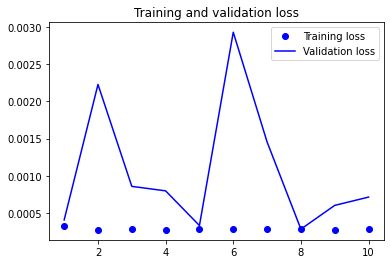

In [49]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

## 构建数据集 进行预测

In [69]:
dataset_total = pd.concat((df['close'][:date.fromisoformat("2020-01-01")],df['close'][date.fromisoformat("2020-01-01"):]),axis=0)

In [112]:
dataset_total

date
1991-04-03    -0.74
1991-04-04    -0.74
1991-04-05    -0.74
1991-04-06    -0.74
1991-04-08    -0.74
              ...  
2022-04-21    15.81
2022-04-22    16.06
2022-04-25    14.85
2022-04-26    14.73
2022-04-27    15.65
Name: close, Length: 7415, dtype: float64

In [113]:
# 获取输入数据
inputs = dataset_total[len(dataset_total) - 561 - 30:].values
inputs


array([15.45, 15.46, 15.19, 15.4 , 15.22, 15.07, 15.09, 14.89, 14.96,
       15.05, 14.91, 15.03, 15.2 , 15.01, 14.93, 15.26, 15.2 , 15.72,
       15.73, 16.1 , 16.06, 16.15, 16.19, 15.84, 16.  , 15.9 , 16.07,
       16.23, 16.17, 16.05, 16.47, 16.78, 16.67, 16.75, 16.26, 16.39,
       16.29, 16.59, 16.36, 16.12, 15.93, 15.99, 16.05, 15.6 , 15.69,
       15.14, 13.59, 14.2 , 14.23, 14.37, 14.22, 14.1 , 14.39, 14.37,
       14.25, 14.63, 14.97, 14.8 , 14.84, 15.19, 15.18, 14.83, 14.64,
       14.59, 14.71, 14.1 , 14.39, 14.32, 14.29, 14.99, 14.63, 14.05,
       14.36, 14.29, 14.28, 14.12, 13.35, 13.01, 12.31, 11.83, 12.12,
       11.75, 12.21, 12.47, 12.66, 12.75, 12.54, 12.4 , 12.49, 12.57,
       12.21, 12.48, 12.38, 12.34, 12.39, 12.19, 12.46, 12.47, 12.28,
       12.49, 12.59, 13.05, 12.83, 12.83, 12.84, 13.1 , 13.12, 13.62,
       13.53, 13.37, 13.29, 13.55, 13.6 , 13.39, 13.23, 12.9 , 12.83,
       12.8 , 12.96, 13.11, 13.  , 12.52, 12.56, 12.64, 12.6 , 12.89,
       12.82, 13.14,

In [115]:
# 归一化
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

C:\Users\12554\miniconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [117]:
inputs[0:5,0]

array([0.92259887, 0.92316384, 0.9079096 , 0.91977401, 0.90960452])

In [84]:
# 准备测试集x_test,进行股价预测
x_test = []
for i in range(30,591):
    x_test.append(inputs[i-30:i,0])
x_test = np.array(x_test) #numpy类型转换
x_test.shape

(561, 30)

In [87]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [88]:
x_test.shape

(561, 30, 1)

In [90]:
predict_test = model.predict(x_test)
#p2 = model.predict()


In [91]:
predict_stock_price = sc.inverse_transform(predict_test)

In [41]:
p2_price = sc.inverse_transform(p2)
p2_price = pd.DataFrame(p2_price)
p2_price.index = test_set.index

In [92]:
predict_stock_price = pd.DataFrame(predict_stock_price)

In [93]:
predict_stock_price.index = test_set.index

In [94]:
predict_stock_price

,0
date,
2020-01-02,15.916824
2020-01-03,16.394468
2020-01-06,16.702293
2020-01-07,16.421135
2020-01-08,16.431410
...,...
2022-04-21,15.845489
2022-04-22,15.894522
2022-04-25,16.123053


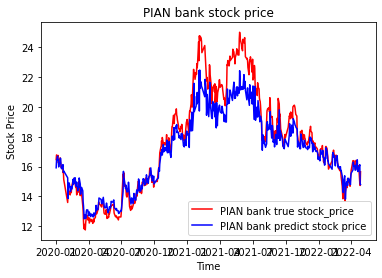

In [97]:
# 绘制测试结果和预测结果是否相符合
plot_predictions(test_set,predict_stock_price,"PIAN bank")

In [98]:
model.save('D:\\000001.XSHG.h5')

In [100]:
from keras.models import load_model
m2 = load_model('D:\\000001.XSHG.h5')